# Step-by-step Guide: Constructing a model with Phydrus, ResIPy and EMagPy

*Authors: Michael Tso*

This notebook is originally part of a manuscript that is currently being prepared (spring 2020): 

*R.A. Collenteur, G. Brunetti, M. Vremec & J. Simunek (in preparation) Phydrus: a Python implementation of the Hydrus-1D model.*

---

This Notebook presents the basics steps to create a Phydrus model simulating water flow through the vadose zone. In the presented example, the workflow is divided into several steps, to demonstrate the usage of Phydrus methods:
1. Import the Phydrus package
2. Create the basic model
3. Add processes and materials
4. Add soil profile
5. Add Root Water Uptake
6. Add atmospheric boundary condition
7. Add observations nodes
8. Simulate the model
9. Post-process the results

Afterwards, examples of coupling Phydrus results to ResIPy and EMagPy are provided:

Surface ERT:

10. Set up R3t model
11. Interpolation and petrophysical transform
12. Run ResIPy forward model
13. Repeat the last two steps in a loop
14. Post-process the results 
___
Andy's problem statement:

***Synthetic model description***

*Geometry*
Upper layer of loamy sand (2m thick) over silty loam.  
Hydraulic properties
Unsaturated properties follow van Genuchten model for water release curve.

Loamy sand:  $\theta$r = 0.057, $\theta$s = 0.41, n = 2.28, $\alpha$ = 12.4 m‐1, Ks = 3.502 m/day

Silty loam:  $\theta$r = 0.067, $\theta$s = 0.45, n = 1.41, $\alpha$ = 2.0 m‐1, Ks = 0.108 m/day

For both soils the tortuosity factor in the unsaturated hydraulic conductivity function = 0.5

*Initial conditions*

Assumed ‘field capacity’ throughout the profile

- 0 < z < 2m,   pressure head = ‐0.4629 m (i.e. moisture content, $\theta$ = 0.0946)
- z > 2 m, pressure head = ‐2.105 m (i.e. $\theta$ = 0.2725)

Note z = 0 at the ground surface.


*Boundary conditions*

- Upper boundary: infiltration of 0.01 m/day for 50 days (i.e. constant).
- Lower boundary: free drainage at 5 m depth.

*Pore fluid*

Assume that this remains constant at 500 $\mu$S/cm, i.e. 50 mS/m.

*Electrical properties*

Assume a Waxman Smits type model for electrical properties of both soils.


$$\sigma=\frac{1}{F}(\sigma_wS^2+\sigma_{surf}S)$$


where 𝜎 is the bulk electrical conductivity, 𝐹 is the formation factor, $\sigma_w$ is the pore fluid
electrical conductivity, 𝑆 is saturation (= $\theta/\theta_s$), $\sigma_{surf}$ is the surface conductivity at saturation
(for the same pore fluid in the system).  

- Loamy sand: 𝐹 = 4.0,  $\sigma_{surf}$ = 2.0 mS/m
- Silty loam: 𝐹 = 6.0,  $\sigma_{surf}$ = 7.0 mS/m

*Geophysical observations*

Made at times: 0, 5, 10, …, 50 days (i.e. 11 observations).

___

**Before you run on Binder**

1. Create a folder called `output_Andy`
2. Compile the hydrus source code:
- Open the terminal, paste `git clone https://github.com/phydrus/source_code.git`
- go to `cd source_code`
- move the make file `mv makefile source`
- go to the source directory `cd source`
- compile the hydrus source code `make hydrus`
- copy the compile hydrus executable to the same directory as the notebook `cp hydrus ../../.`
- go back to the original directory `cd ../../.`


### 1. Import the Pydrus package

In [1]:
import os
 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import phydrus as ps
os.getcwd()

'/data/notebooks/jupyterlab-integration/temp/phydrus/examples/phydrus_paper/Ex1'

### 2. Create the basic model & add time information
In the code block below a `Model` instance is created. The path to the Hydrus-1D executable has to be set at this stage. Phydrus will check the executable, and raise an Error if it is not found. 

In [2]:
#Folder where the Hydrus files are to be stored
ws = "output_Andy"
exe = os.path.join(os.getcwd(), "./hydrus")

# Create model
ml = ps.Model(exe_name=exe, ws_name=ws, name="model",
              time_unit="days", length_unit="cm",print_screen=True) # some issues for setting `length_unit = 'm', avoid

ml.add_time_info(tinit=0, tmax=50,print_times=True,dtprint=0.5);

In [3]:
#?ml.add_time_info

### 3. Add processes and materials
In this step a model for the water flow is selected and top and bottom boundary conditions, using the `ml.add_waterflow` method. After that, we can use the `get_empty_material_df` method to obtain an empty DataFrame to define our soil hydraulic parameters for the different soil materials. In this example, the model contains to soil materials.

VG model (`model=0`)

Boundary conditions:
- top: constant infiltration of 0.01 m/d (i.e. constant flux, `top_bc=1, rtop=0.01 (I think negative means infiltration?)`)
- bottom: free drainage (`bot_bc=4`)

In [4]:
ml.add_waterflow(model=0, top_bc=1, rtop=0.01*-100, bot_bc=4) # top3 = Atmospheric Boundary Condition with Surface Run Off. bot4 = free drainage

m = ml.get_empty_material_df(n=2) # loamy sand over silty loam
m.loc[0:2] = [[0.057, 0.41, 12.4/100, 2.28, 3.502*100, 0.5],  #columns=["thr", "ths", "Alfa", "n" "Ks", "l"]
              [0.067, 0.45, 2.0/100, 1.41, 0.108*100, 0.5]]
ml.add_material(m)

In [5]:
m

water                               
     thr   ths   Alfa     n     Ks    l
1  0.057  0.41  0.124  2.28  350.2  0.5
2  0.067  0.45  0.020  1.41   10.8  0.5

### 4. Add Profile information
The profile is a simple one based on depth.

(-3.0, 0.0)

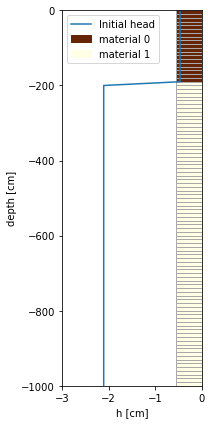

In [6]:
def z_loop(z, z1):
    if z > z1:
        return -0.4629
    else:
        return -2.105

bottom = [-2*100, -10*100]  # Depth of the soil column, need to adjust bottom of first layer with dx

profile = ps.create_profile(bot=bottom, dx=10, mat=[1,2])
profile["h"] = profile.apply(lambda row: z_loop(row["x"], -2*100), axis=1)
#profile["Beta"] = profile.apply(lambda row: z_loop(row["x"]), axis=1)
ml.add_profile(profile)
ml.plots.profile(figsize=(3,6))
plt.xlim([-3.0,0])

### 5. Add atmospheric boundary conditions
Atmospheric boundary condition can be added easily by reading in a CSV file using Pandas `read_csv` method and adding it to the model. 

In [7]:
# ET: https://github.com/phydrus/phydrus/issues/5
#atm = pd.read_csv("../data/atmosphere.csv", index_col=0)
#ml.add_atmospheric_bc(atm, hcrits=0)


### 6. Add root water uptake

In [8]:
#ml.add_root_uptake(model=0, p2h=-1500, p2l=-1500, poptm=[-25, -25])

### 7. Add observation nodes

In [9]:
#Number of the node -- > write script to get node closest to desired depth
ml.add_obs_nodes([-1*100, -3*100])

### 8. Write hydrus input files & run hydrus 
Before we can simulate, we write all model information to files. 

Note: *gfortran* and *wine* needed in Linux systems

In [10]:
ml.write_input()
ml.simulate()

INFO: Successfully wrote output_Andy/SELECTOR.IN
INFO: Successfully wrote output_Andy/PROFILE.DAT
INFO: Hydrus-1D Simulation Successful.


CompletedProcess(args=['/data/notebooks/jupyterlab-integration/temp/phydrus/examples/phydrus_paper/Ex1/./hydrus', 'output_Andy', '-1'], returncode=0)

In [11]:
ml.profile

,x,h,Mat,Lay,Beta,Axz,Bxz,Dxz,Temp,Conc,SConc
1,0.0,-0.4629,1,1,0,1.0,1.0,1.0,20.0,,
2,-10.0,-0.4629,1,1,0,1.0,1.0,1.0,20.0,,
3,-20.0,-0.4629,1,1,0,1.0,1.0,1.0,20.0,,
4,-30.0,-0.4629,1,1,0,1.0,1.0,1.0,20.0,,
5,-40.0,-0.4629,1,1,0,1.0,1.0,1.0,20.0,,
...,...,...,...,...,...,...,...,...,...,...,...
97,-960.0,-2.1050,2,1,0,1.0,1.0,1.0,20.0,,
98,-970.0,-2.1050,2,1,0,1.0,1.0,1.0,20.0,,
99,-980.0,-2.1050,2,1,0,1.0,1.0,1.0,20.0,,
100,-990.0,-2.1050,2,1,0,1.0,1.0,1.0,20.0,,


### 9a. Plot results
Plot pressure for soil column at the end of the simulation.


In [12]:
from scipy import interpolate

lines = ml.plots.soil_properties(figsize=(6, 2.5))
plt.close()
x = lines[0].get_children()[0].get_data()[0]
y = lines[0].get_children()[0].get_data()[1]
#print('Field_capacitiy=',interpolate.interp1d(x, y)(-10.197))

/data/conda/new-environment/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/data/conda/new-environment/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/data/conda/new-environment/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/data/conda/new-environment/lib/python3.9/site-packages/pandas/plotting/_matplo

/data/conda/new-environment/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/data/conda/new-environment/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/data/conda/new-environment/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/data/conda/new-environment/lib/python3.9/site-packages/pandas/plotting/_matplo

array([<AxesSubplot:xlabel='h', ylabel='theta'>,
       <AxesSubplot:xlabel='log_h'>], dtype=object)

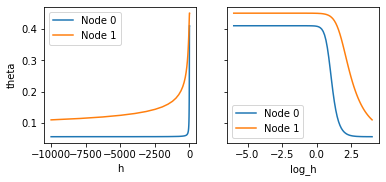

In [13]:
ml.plots.soil_properties(figsize=(6, 2.5))
#plt.savefig("../../figures/soil_properties.eps", bbox_inches="tight", dpi=300)

### 9b. Plot the drainage over time

/data/conda/new-environment/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/data/conda/new-environment/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


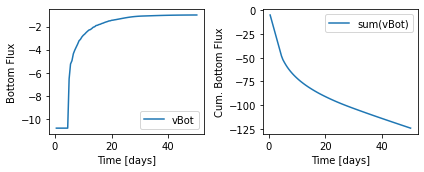

In [14]:
axes = ml.plots.water_flow("Bottom Flux", figsize=(6, 2.5))
#plt.savefig("../../figures/water_flow.eps", bbox_inches="tight", dpi=300)

### 9c. Plot the water content over time

(0.0, 50.0)

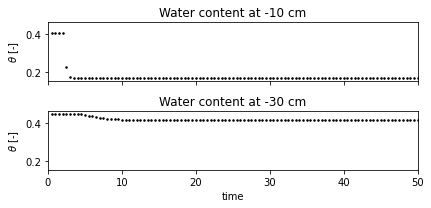

In [15]:
df = ml.read_obs_node()

fig, [ax0, ax1] = plt.subplots(2,1, figsize=(6,3), sharex=True, sharey=True)
df[ml.obs_nodes[0]]["theta"].plot(ax=ax0, marker=".", c="k", linestyle="", markersize=3)
ax0.set_title("Water content at -10 cm")
ax0.set_ylabel(r"$\theta$ [-]")

df[ml.obs_nodes[1]]["theta"].plot(ax=ax1, marker=".", c="k", linestyle="", markersize=3)
ax1.set_title("Water content at -30 cm")
ax1.set_ylabel(r"$\theta$ [-]")
plt.tight_layout()
ax1.set_xlim(0,50)
#plt.savefig("../../figures/water_content.eps", bbox_inches="tight", dpi=300)

In [16]:
#df[ml.obs_nodes[0]].to_csv("../data/wc_30cm.csv")
#df[ml.obs_nodes[1]].to_csv("../data/wc_60cm.csv")
ml.read_nod_inf(times=[10]).head()

,Node,Depth,Head,Moisture,K,C,Flux,Sink,Kappa,v/KsTop,Temp
1,1,0.0,-19.214,0.1656,1.0,0.006391,-1.0,0.0,-1,-0.00286,20.0
2,2,-10.0,-19.214,0.1656,1.0,0.006391,-1.0,0.0,-1,-0.00286,20.0
3,3,-20.0,-19.214,0.1656,1.0,0.006391,-1.0,0.0,-1,-0.00286,20.0
4,4,-30.0,-19.214,0.1656,1.0,0.006391,-1.0,0.0,-1,-0.00286,20.0
5,5,-40.0,-19.214,0.1656,1.0,0.006391,-1.0,0.0,-1,-0.00286,20.0


### 9c. Update the soil profile plot with the pressure head

Text(0.5, 1.0, 'Day 10')

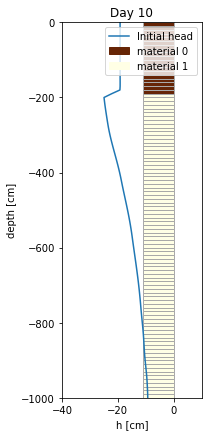

In [17]:
head = ml.read_nod_inf(times=[10]).loc[:,'Head']
ml.profile.loc[:, "h"] = head
ml.plots.profile()
plt.xlim([-40, 10])
plt.title('Day 10')

In [18]:
ml.read_nod_inf(times=[2.5])

,Node,Depth,Head,Moisture,K,C,Flux,Sink,Kappa,v/KsTop,Temp
1,1,0.0,-19.212,0.1656,1.000,0.006392,-1.000,0.0,-1,-0.00286,20.0
2,2,-10.0,-19.205,0.1656,1.001,0.006396,-1.000,0.0,-1,-0.00286,20.0
3,3,-20.0,-19.183,0.1658,1.005,0.006406,-1.002,0.0,-1,-0.00286,20.0
4,4,-30.0,-19.140,0.1660,1.011,0.006427,-1.006,0.0,-1,-0.00287,20.0
5,5,-40.0,-19.070,0.1664,1.021,0.006461,-1.014,0.0,-1,-0.00289,20.0
...,...,...,...,...,...,...,...,...,...,...,...
97,97,-960.0,83.200,0.4500,10.800,0.000000,-10.800,0.0,-1,-0.03080,20.0
98,98,-970.0,83.200,0.4500,10.800,0.000000,-10.800,0.0,-1,-0.03080,20.0
99,99,-980.0,83.200,0.4500,10.800,0.000000,-10.800,0.0,-1,-0.03080,20.0
100,100,-990.0,83.200,0.4500,10.800,0.000000,-10.800,0.0,-1,-0.03080,20.0


(-30.0, 5.0)

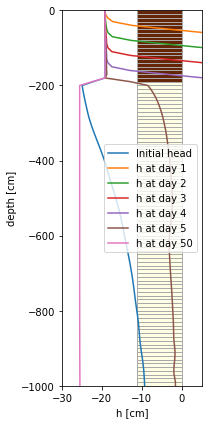

In [19]:
ml.profile.loc[:, "h0"] = ml.read_nod_inf(times=[0]).loc[:,'Head']
ml.profile.loc[:, "h1"] = ml.read_nod_inf(times=[1]).loc[:,'Head']
ml.profile.loc[:, "h2"] = ml.read_nod_inf(times=[2]).loc[:,'Head']
ml.profile.loc[:, "h3"] = ml.read_nod_inf(times=[3]).loc[:,'Head']
ml.profile.loc[:, "h4"] = ml.read_nod_inf(times=[4]).loc[:,'Head']
ml.profile.loc[:, "h5"] = ml.read_nod_inf(times=[5]).loc[:,'Head']
ml.profile.loc[:, "h50"] = ml.read_nod_inf(times=[50]).loc[:,'Head']
ml.plots.profile()
plt.plot(ml.profile.loc[:, ["h1"]].values,ml.profile.loc[:, ["x"]].values,label="h at day 1")
plt.plot(ml.profile.loc[:, ["h2"]].values,ml.profile.loc[:, ["x"]].values,label="h at day 2")
plt.plot(ml.profile.loc[:, ["h3"]].values,ml.profile.loc[:, ["x"]].values,label="h at day 3")
plt.plot(ml.profile.loc[:, ["h4"]].values,ml.profile.loc[:, ["x"]].values,label="h at day 4")
plt.plot(ml.profile.loc[:, ["h5"]].values,ml.profile.loc[:, ["x"]].values,label="h at day 5")
plt.plot(ml.profile.loc[:, ["h50"]].values,ml.profile.loc[:, ["x"]].values,label="h at day 50")

plt.legend(loc='best')
plt.xlim([-30, 5])



Text(0, 0.5, 'depth [cm]')

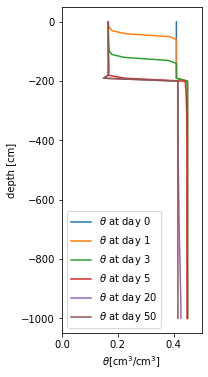

In [20]:

plt.figure(figsize=(2.5,6))
ml.profile.loc[:, "m0"] = ml.read_nod_inf(times=[0]).loc[:,'Moisture']
ml.profile.loc[:, "m1"] = ml.read_nod_inf(times=[1]).loc[:,'Moisture']
ml.profile.loc[:, "m3"] = ml.read_nod_inf(times=[3]).loc[:,'Moisture']
ml.profile.loc[:, "m5"] = ml.read_nod_inf(times=[5]).loc[:,'Moisture']
ml.profile.loc[:, "m20"] = ml.read_nod_inf(times=[20]).loc[:,'Moisture']
ml.profile.loc[:, "m50"] = ml.read_nod_inf(times=[50]).loc[:,'Moisture']
plt.plot(ml.profile.loc[:, ["m0"]].values,ml.profile.loc[:, ["x"]].values,label=r'$\theta$ at day 0')
plt.plot(ml.profile.loc[:, ["m1"]].values,ml.profile.loc[:, ["x"]].values,label=r'$\theta$ at day 1')
plt.plot(ml.profile.loc[:, ["m3"]].values,ml.profile.loc[:, ["x"]].values,label=r'$\theta$ at day 3')
plt.plot(ml.profile.loc[:, ["m5"]].values,ml.profile.loc[:, ["x"]].values,label=r'$\theta$ at day 5')
plt.plot(ml.profile.loc[:, ["m20"]].values,ml.profile.loc[:, ["x"]].values,label=r'$\theta$ at day 20')
plt.plot(ml.profile.loc[:, ["m50"]].values,ml.profile.loc[:, ["x"]].values,label=r'$\theta$ at day 50')

plt.xlim([0,0.5])
plt.legend()
plt.xlabel(r"$\theta \mathrm{[cm^3/cm^3]}$")
plt.ylabel(f"depth [{ml.basic_info['LUnit']}]")

# Geophysics

## Surface survey




In [21]:
# example to obtain saturation from Hydrus
ml.read_nod_inf(times=[1]).loc[:,'Moisture'].values/ml.materials['water','ths'][ml.profile['Mat']].values


array([0.40341463, 0.40487805, 0.41365854, 0.43902439, 0.55731707,
       0.94268293, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

### 10. Load ResiPy and create mesh

In [22]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
sys.path.append((os.path.relpath('../src'))) # add here the relative path of the API folder

import numpy as np # numpy for electrode generation
from resipy import Project

API path =  /data/conda/new-environment/lib/python3.9/site-packages/resipy
ResIPy version =  3.3.2
cR2.exe found and up to date.
R3t.exe found and up to date.
cR3t.exe found and up to date.


/data/conda/new-environment/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Working directory is: /data/notebooks/jupyterlab-integration/temp/phydrus/examples/phydrus_paper/Ex1/output_Andy
clearing dirname
Creating quadrilateral mesh...done (4332 elements)


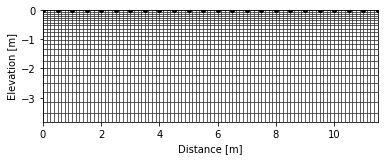

In [23]:
k = Project(typ='R2',dirname='output_Andy') # create R2 object 
elec = np.zeros((24,3))
elec[:,0] = np.arange(0, 24*0.5, 0.5) # with 0.5 m spacing and 24 electrodes
k.setElec(elec)
k.createMesh(typ='quad', show_output=False, res0=200) # let's create the mesh based on these electrodes position
k.showMesh()

### 11. Petrophysical transform
> Very important to get element centres of the mesh

> Make sure to convert moisture content to saturation

In [24]:
#help(k.mesh) # cool!
ec = k.mesh.elmCentre # ERT mesh centres
ec = np.c_[ec, np.ones(len(ec[:,0]))] # region number
ec[ec[:,2]<-2,3] = 2 # define region 2


# interpolate
from scipy import interpolate
f = interpolate.interp1d(
        ml.profile.loc[:, ["x"]].values.flatten()/100,      
        ml.read_nod_inf(times=[4]).loc[:,'Moisture'].values/ml.materials['water','ths'][ml.profile['Mat']].values,  # this is Saturation = theta/thetas by Matertial 
           fill_value='extrapolate') # (hydrus moisture, hydrus grid z, ERT grid z)
Sat = f(ec[:,2])

# Petrophysical transform
tt = 0 # day 0
f = interpolate.interp1d(
        ml.profile.loc[:, ["x"]].values.flatten()/100,      # convert m from cm
        ml.read_nod_inf(times=[tt]).loc[:,'Moisture'].values/ml.materials['water','ths'][ml.profile['Mat']].values,  # this is Saturation = theta/thetas by Matertial 
           fill_value='extrapolate') # (hydrus moisture, hydrus grid z, ERT grid z)
Sat = f(ec[:,2])
F = 4.0; sigma_surf = 0.002; sigma_f = 0.05      # material 1
sigma = 1/F*(sigma_f*Sat**2+sigma_surf*Sat)
F = 6.0; sigma_surf = 0.007; sigma_f = 0.05      # material 2
sigma[ec[:,3]==2]  = 1/F*(sigma_f*Sat[ec[:,3]==2]**2+sigma_surf*Sat[ec[:,3]==2])

#plt.plot(ml.read_nod_inf(times=[10]).loc[:,'Moisture'].values,ml.profile.loc[:, ["x"]].values.flatten()/100,'.')
#plt.figure()
#plt.plot(Sat,ec[:,2],'o')
#plt.figure()
#plt.plot(ec[:,3],ec[:,2],'o')

/data/conda/new-environment/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 12. write to ResIPy and run model
This will involed write the resistivity values to the R2 foward model via ResIPy. 

- `k.setRefModel()` writes the forward model by mesh element. It requires an array.
- `k.forward()` runs the forward model
- `k.getResults()` grabs the latest results
- `k.showResults()` plot the resistivity model. Note `index=0` refers to the forward model.

Reference model successfully assigned
Writing .in file and mesh.dat... done
Creating sequence... 140 quadrupoles generated.
done
Writing protocol.dat... done
Running forward model... 

 >> R  2    R e s i s t i v i t y   I n v e r s i o n   v4.02 <<

 >> D a t e : 10 - 11 - 2021
 >> My beautiful survey                                                             
 >> F o r w a r d   S o l u t i o n   S e l e c t e d <<
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading start resistivity from resistivity.dat               

 Measurements read:   140     Measurements rejected:     0

 >> Total Memory required is:          0.395 Gb
0/140 reciprocal measurements found.
Forward modelling done.
ERROR: No sensitivity attribute found


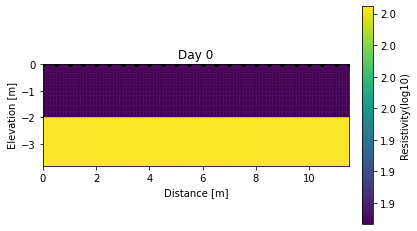

In [25]:
k.setRefModel(1/sigma)
k.forward(noise=0.0, iplot=False) # forward modelling with 5 % noise added to the output 

# collect output
k.getResults()
k.showResults(index=0) # show the initial model
plt.title('Day '+str(tt))
# read results
fwd_dir = os.path.relpath('output_Andy/invdir/fwd/')
obs_data = np.loadtxt(os.path.join(fwd_dir, 'R2_forward.dat'),skiprows =1)
obs_data = obs_data[:,6]

### 13. loop through time steps (repeat steps a-c) and plot resistivity models

In [26]:
%%time
times = np.linspace(0,50,11)
appended_data = []
fig, ax = plt.subplots(int(np.ceil(len(times)/3)), 3)
ax = ax.flatten()


ii=0
for tt in times:
    df2 = pd.DataFrame({})
    
    # Petrophysical transform
    f = interpolate.interp1d(
            ml.profile.loc[:, ["x"]].values.flatten()/100,      # convert m from cm
            ml.read_nod_inf(times=[tt]).loc[:,'Moisture'].values/ml.materials['water','ths'][ml.profile['Mat']].values,  # this is Saturation = theta/thetas by Matertial 
               fill_value='extrapolate') # (hydrus moisture, hydrus grid z, ERT grid z)
    Sat = f(ec[:,2])
    F = 4.0; sigma_surf = 0.002; sigma_f = 0.05      # material 1
    sigma = 1/F*(sigma_f*Sat**2+sigma_surf*Sat)
    F = 6.0; sigma_surf = 0.007; sigma_f = 0.05      # material 2
    sigma[ec[:,3]==2]  = 1/F*(sigma_f*Sat[ec[:,3]==2]**2+sigma_surf*Sat[ec[:,3]==2])
    
    if ii==0:
        sigma_all = sigma
    else:
        sigma_all = np.c_[sigma_all, sigma]
        
    
    # collect results
    k.setRefModel(1/sigma)  # probably should record this too
    k.forward(noise=0.0, iplot=False)
    k.getResults() # important! at them moment latest results are not grabbed after running forward model
    k.showResults(index=0,ax=ax[ii] )# , vmin=2.5,vmax=3.5)
    
    #if ii == 0:
    #    k.showResults(index=0,ax=ax[ii])
    #    start_res =  k.meshResults[0].df['Resistivity(ohm.m)'].values # note this is cropped
    #else:
    #    k.meshResults[0].df['Res. Difference (%)'] = (k.meshResults[0].df['Resistivity(ohm.m)'] - start_res) / start_res * 100
    #    k.showResults(index=0,ax=ax[ii], attr='Res. Difference (%)',color_map ='RdBu', )
        
    ax[ii].set_title('Day '+str(tt))

    df2['data'] = np.loadtxt(os.path.join(fwd_dir, 'R2_forward.dat'),skiprows =1)[:,6]
    df2['time']=tt
    appended_data.append(df2)
    ii+=1

plt.close() #hide fig
    
appended_data = pd.concat(appended_data)




/data/conda/new-environment/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Reference model successfully assigned
Writing .in file and mesh.dat... done
Writing protocol.dat... done
Running forward model... 

 >> R  2    R e s i s t i v i t y   I n v e r s i o n   v4.02 <<

 >> D a t e : 10 - 11 - 2021
 >> My beautiful survey                                                             
 >> F o r w a r d   S o l u t i o n   S e l e c t e d <<
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading start resistivity from resistivity.dat               

 Measurements read:   140     Measurements rejected:     0

 >> Total Memory required is:          0.395 Gb
0/140 reciprocal measurements found.
Forward modelling done.
ERROR: No sensitivity attribute found
Reference model successfully assigned
Writing .in file and mesh.dat... done
Writing protocol.dat... done
Running forward model... 

 >> R  2    R e s i s t i v i t y   I n v e r s i o n   v4.02 <<

 >> D a t e : 10 - 11 - 2

/data/conda/new-environment/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


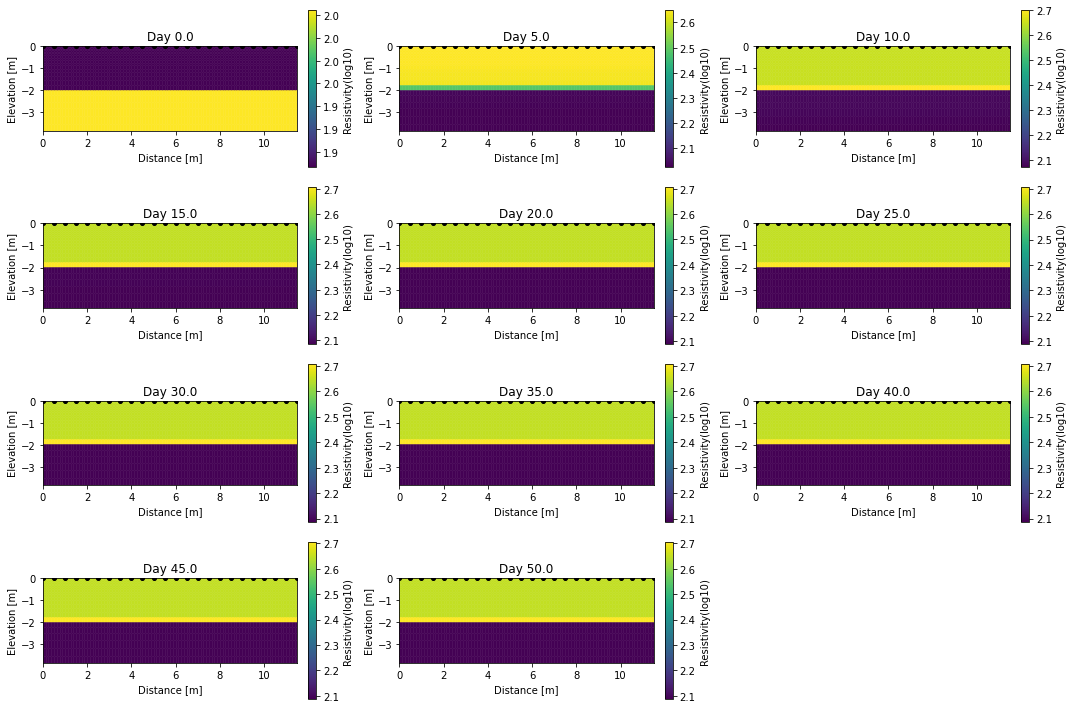

In [27]:
fig.set_figheight(10)
fig.set_figwidth(15)
ax[-1].axis('off')

fig.tight_layout()
fig


### 14. Same as 10d but plot difference

In [28]:
%%time
# repeat previous but plot resistivity difference

times = np.linspace(0,50,11)
appended_data = []
fig, ax = plt.subplots(int(np.ceil(len(times)/3)), 3)
ax = ax.flatten()


ii=0
for tt in times:
    df2 = pd.DataFrame({})
    
    # Petrophysical transform
    f = interpolate.interp1d(
            ml.profile.loc[:, ["x"]].values.flatten()/100,      # convert m from cm
            ml.read_nod_inf(times=[tt]).loc[:,'Moisture'].values/ml.materials['water','ths'][ml.profile['Mat']].values,  # this is Saturation = theta/thetas by Matertial 
               fill_value='extrapolate') # (hydrus moisture, hydrus grid z, ERT grid z)
    Sat = f(ec[:,2])
    F = 4.0; sigma_surf = 0.002; sigma_f = 0.05      # material 1
    sigma = 1/F*(sigma_f*Sat**2+sigma_surf*Sat)
    F = 6.0; sigma_surf = 0.007; sigma_f = 0.05      # material 2
    sigma[ec[:,3]==2]  = 1/F*(sigma_f*Sat[ec[:,3]==2]**2+sigma_surf*Sat[ec[:,3]==2])
    
    if ii==0:
        sigma_all = sigma
    else:
        sigma_all = np.c_[sigma_all, sigma]
        
    
    # collect results
    k.setRefModel(1/sigma)  # probably should record this too
    k.forward(noise=0.0, iplot=False)
    k.getResults() # important! at them moment latest results are not grabbed after running forward model
    #k.showResults(index=0,ax=ax[ii] )# , vmin=2.5,vmax=3.5)
    
    if ii == 0:
        k.showResults(index=0,ax=ax[ii])
        start_res =  k.meshResults[0].df['Resistivity(ohm.m)'].values # note this is cropped
    else:
        k.meshResults[0].df['Res. Difference (%)'] = (k.meshResults[0].df['Resistivity(ohm.m)'] - start_res) / start_res * 100
        k.showResults(index=0,ax=ax[ii], attr='Res. Difference (%)',color_map ='RdBu', )
        
    ax[ii].set_title('Day '+str(tt))

    df2['data'] = np.loadtxt(os.path.join(fwd_dir, 'R2_forward.dat'),skiprows =1)[:,6]
    df2['time']=tt
    appended_data.append(df2)
    ii+=1

plt.close() #hide fig
    
appended_data = pd.concat(appended_data)


Reference model successfully assigned
Writing .in file and mesh.dat... done
Writing protocol.dat... done
Running forward model... 

 >> R  2    R e s i s t i v i t y   I n v e r s i o n   v4.02 <<

 >> D a t e : 10 - 11 - 2021
 >> My beautiful survey                                                             
 >> F o r w a r d   S o l u t i o n   S e l e c t e d <<
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading start resistivity from resistivity.dat               

 Measurements read:   140     Measurements rejected:     0

 >> Total Memory required is:          0.395 Gb
0/140 reciprocal measurements found.
Forward modelling done.
ERROR: No sensitivity attribute found
Reference model successfully assigned
Writing .in file and mesh.dat... done
Writing protocol.dat... done
Running forward model... 

 >> R  2    R e s i s t i v i t y   I n v e r s i o n   v4.02 <<

 >> D a t e : 10 - 11 - 2

/data/conda/new-environment/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


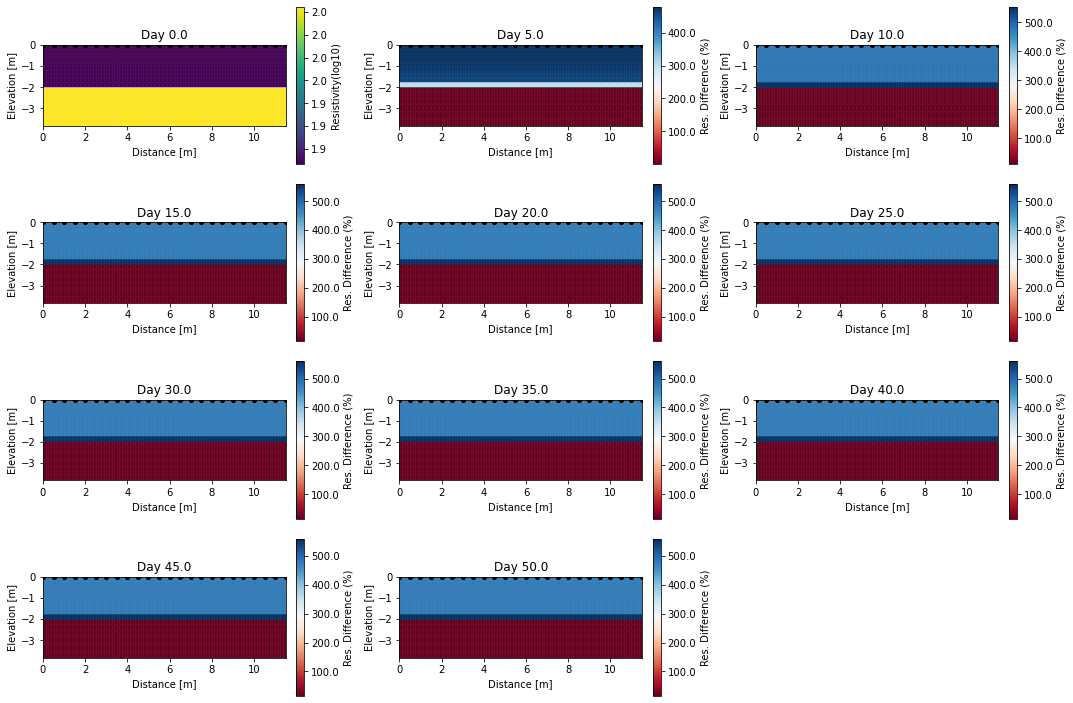

In [29]:
fig.set_figheight(10)
fig.set_figwidth(15)
ax[-1].axis('off')

fig.tight_layout()
fig


### 16. Synthetic data
We have stored the synthetic data in `appended_data` if we need them later (e.g. for inversion). We have also stored the resisitivity and mesh information.

In [30]:
appended_data = appended_data.reset_index().pivot(index ='index',columns='time', values='data') # pivot and add elec if needed
appended_data

time,0.0,5.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0
index,,,,,,,,,,,
0,74.31352,433.62534,433.15319,433.12611,433.12130,433.11963,433.11904,433.11883,433.11872,433.11868,433.11866
1,74.22751,433.11101,432.64390,432.61699,432.61219,432.61053,432.60993,432.60972,432.60961,432.60957,432.60955
2,74.21200,433.01088,432.54534,432.51850,432.51371,432.51205,432.51146,432.51125,432.51114,432.51110,432.51108
3,74.20766,432.98148,432.51604,432.48922,432.48444,432.48278,432.48219,432.48198,432.48187,432.48183,432.48181
4,74.20607,432.97106,432.50538,432.47857,432.47380,432.47214,432.47155,432.47134,432.47123,432.47119,432.47117
...,...,...,...,...,...,...,...,...,...,...,...
135,80.19402,348.17549,373.28811,374.16081,374.22682,374.18146,374.16315,374.15293,374.14588,374.14252,374.14132
136,80.21030,348.24183,373.36305,374.23588,374.30182,374.25640,374.23807,374.22784,374.22078,374.21742,374.21622
137,80.24027,348.38431,373.52014,374.39308,374.45889,374.41339,374.39503,374.38477,374.37771,374.37435,374.37314


/data/conda/new-environment/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:title={'center':'index=5'}, xlabel='time'>

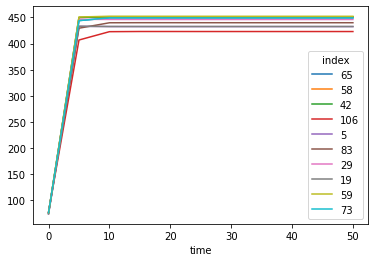

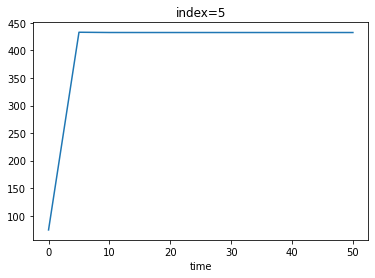

In [31]:
appended_data.sample(n=10, random_state=1).T.plot()
plt.figure()
appended_data.iloc[5].plot(title='index=5')

In [32]:
k.meshResults[0].df

/data/conda/new-environment/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,param,elm_id,region,cellType,X,Y,Z,Resistivity(ohm.m),Resistivity(log10),Conductivity(mS/m),Res. Difference (%)
0,1,1,1.0,9.0,0.0625,0.0,-0.027500,446.196,2.64953,2.241168,479.222573
1,2,2,1.0,9.0,0.0625,0.0,-0.085250,446.196,2.64953,2.241168,479.222573
2,3,3,1.0,9.0,0.0625,0.0,-0.148775,446.196,2.64953,2.241168,479.222573
3,4,4,1.0,9.0,0.0625,0.0,-0.218655,446.196,2.64953,2.241168,479.222573
4,5,5,1.0,9.0,0.0625,0.0,-0.295520,446.196,2.64953,2.241168,479.222573
...,...,...,...,...,...,...,...,...,...,...,...
2019,2020,2020,1.0,9.0,11.4375,0.0,-2.368955,122.443,2.08793,8.167065,15.691258
2020,2021,2021,1.0,9.0,11.4375,0.0,-2.660850,122.443,2.08793,8.167065,15.691258
2021,2022,2022,1.0,9.0,11.4375,0.0,-2.981935,122.443,2.08793,8.167065,15.691258
2022,2023,2023,1.0,9.0,11.4375,0.0,-3.335130,122.443,2.08793,8.167065,15.691258


In [33]:
sigma_all[:,0]

/data/conda/new-environment/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.01298135, 0.01298135, 0.01298135, ..., 0.00944855, 0.00944855,
       0.00944855])

## Cross-borehole survey
... to be added

## EMI

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from emagpy import Problem

times =[0,5,10,15,20,25,30,35,40,45,50]

# parameters for the synthetic model
coils = ['VCP4.49f10000h0', 'VCP4.49f10000h1']

# heterogeneous ground
#condsHetero = np.ones((100,2))*np.arange(100)[:,None]+1
#condsHetero[:,1] = 50
#depths = np.ones((100,1))*0.5

z_hydrus = ml.profile.loc[:, ["x"]].values.flatten()/100
depths = abs(ml.profile.loc[:, ["x"]].diff().values.flatten()/100)[1:].reshape(1,-1)
#depths = np.repeat(depths, len(times), axis=0).shape # repeat for all times
sat_nod = ml.read_nod_inf(times=[5]).loc[:,'Moisture'].values/ml.materials['water','ths'][ml.profile['Mat']].values  # this is Saturation = theta/thetas by Matertial 

# petrophysical transform
F = 4.0; sigma_surf = 0.002; sigma_f = 0.05      # material 1
sigma_nod = 1/F*(sigma_f*sat_nod**2+sigma_surf*sat_nod)
F = 6.0; sigma_surf = 0.007; sigma_f = 0.05      # material 2
sigma_nod[z_hydrus <-2] = 1/F*(sigma_f*sat_nod[z_hydrus <-2]**2+sigma_surf*sat_nod[z_hydrus <-2])

condsHetero = 0.5*(sigma_nod[:-1]+sigma_nod[1:])*1000 # nodal to ec, convert to mS/m
condsHetero = np.r_[condsHetero,condsHetero[-1]] # emagpy requires padding for the last depth for infinite depth
condsHetero = condsHetero.reshape(1,-1)

# forward modelling
kEM = Problem()
kEM.setModels([depths],[condsHetero])
dfsFSeq = kEM.forward(forwardModel='FSeq', coils=coils)
dfsFSlin = kEM.forward(forwardModel='FSlin', coils=coils)
dfsCS = kEM.forward(forwardModel='CS', coils=coils)

/data/conda/new-environment/lib/python3.9/site-packages/emagpy/invertHelper.py:287: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  R = np.zeros((sigmaLen, len(lamb)), dtype=np.complex)#*np.nan


Forward modelling
Forward modelling
Forward modelling


### loop through the time steps

In [35]:
## time-lapse


def get_conds(tt,ml):
    # tt = time stamp
    # ml = hydrus model
    sat_nod=ml.read_nod_inf(times=[tt]).loc[:,'Moisture'].values/ml.materials['water','ths'][ml.profile['Mat']].values  # this is Saturation = theta/thetas by Matertial 
    z_hydrus = ml.profile.loc[:, ["x"]].values.flatten()/100
    F = 4.0; sigma_surf = 0.002; sigma_f = 0.05      # material 1
    sigma_nod = 1/F*(sigma_f*sat_nod**2+sigma_surf*sat_nod)
    F = 6.0; sigma_surf = 0.007; sigma_f = 0.05      # material 2
    sigma_nod[z_hydrus <-2] = 1/F*(sigma_f*sat_nod[z_hydrus <-2]**2+sigma_surf*sat_nod[z_hydrus <-2])
    condsHetero = 0.5*(sigma_nod[:-1]+sigma_nod[1:])*1000 # nodal to ec, convert to mS/m
    condsHetero = np.r_[condsHetero,condsHetero[-1]] # emagpy requires padding for the last depth for infinite depth
    condsHetero = condsHetero.reshape(1,-1)
    return condsHetero


# forward modelling
kEM = Problem()
kEM.setModels([depths, depths, depths, depths, depths, depths, depths, depths, depths, depths, depths],\
              [get_conds(0.0,ml), get_conds(5.0,ml),get_conds(10.0,ml),get_conds(15.0,ml),get_conds(20.0,ml),get_conds(25.0,ml),\
               get_conds(30.0,ml),get_conds(35.0,ml),get_conds(40.0,ml),get_conds(45.0,ml),get_conds(50.0,ml)])
#kEM.setModels([depths, depths], [get_conds(0.0,ml), get_conds(5.0,ml)])
dfsFSeq = kEM.forward(forwardModel='FSeq', coils=coils)
dfsFSlin = kEM.forward(forwardModel='FSlin', coils=coils)
dfsCS = kEM.forward(forwardModel='CS', coils=coils)

# concatenate datafframe
dfsFSeq = pd.concat(dfsFSeq); dfsFSeq['Day'] = times; 
dfsFSlin = pd.concat(dfsFSlin); dfsFSlin['Day'] = times; 
dfsCS = pd.concat(dfsCS); dfsCS['Day'] = times; 


Forward modelling
Forward modelling
Forward modelling


### Plot results

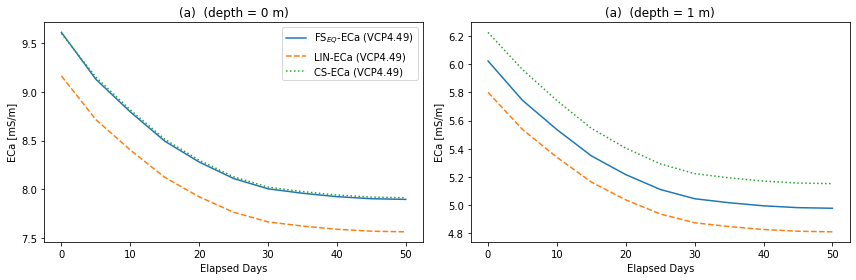

In [36]:

# figure

fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(12, 4))
axs = axs.flatten()
ax = axs[0]
ax.set_title('(a)  (depth = 0 m)')
ax.plot(times, dfsFSeq[coils[0]], '-', label = r'FS$_{EQ}$-ECa (VCP4.49)',marker='')
ax.plot(times, dfsFSlin[coils[0]], '--', label = 'LIN-ECa (VCP4.49)')
ax.plot(times, dfsCS[coils[0]], ':', label = 'CS-ECa (VCP4.49)')
ax.set_ylabel('ECa [mS/m]')
ax.set_xlabel('Elapsed Days')
ax.legend()

ax = axs[1]
ax.set_title('(a)  (depth = 1 m)')
ax.plot(times, dfsFSeq[coils[1]], '-')
ax.plot(times, dfsFSlin[coils[1]], '--')
ax.plot(times, dfsCS[coils[1]], ':')
ax.set_ylabel('ECa [mS/m]')
ax.set_xlabel('Elapsed Days')



fig.tight_layout()

## scratch, ignore below

In [37]:
k.param

/data/conda/new-environment/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'mesh_type': 6,
 'node_elec': [array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
         '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
         '24'], dtype='<U2'),
  array([ 430,  586,  742,  898, 1054, 1210, 1366, 1522, 1678, 1834, 1990,
         2146, 2302, 2458, 2614, 2770, 2926, 3082, 3238, 3394, 3550, 3706,
         3862, 4018])],
 'mesh': <resipy.meshTools.Mesh at 0x7f258d7bc130>,
 'num_regions': 0,
 'res0File': 'Start_res.dat',
 'reqMemory': 20.736292118528,
 'num_xz_poly': 5,
 'xz_poly_table': array([[ 0.        ,  0.        ],
        [11.5       ,  0.        ],
        [11.5       , -3.83333333],
        [ 0.        , -3.83333333],
        [ 0.        ,  0.        ]]),
 'reg_mode': 1}

In [38]:
k.surveys[0].df

,index,a,b,m,n,resist,ip,resError,phaseError,K,app,irecip,reciprocalErrRel,recipError,recipMean,reci_IP_err
0,1.0,1,2,3,4,-45.955317,NaN,NaN,NaN,-18.849556,866.237324,0,NaN,NaN,-45.955317,NaN
1,2.0,2,3,4,5,-45.901299,NaN,NaN,NaN,-18.849556,865.219109,0,NaN,NaN,-45.901299,NaN
2,3.0,3,4,5,6,-45.890851,NaN,NaN,NaN,-18.849556,865.022159,0,NaN,NaN,-45.890851,NaN
3,4.0,4,5,6,7,-45.887746,NaN,NaN,NaN,-18.849556,864.963626,0,NaN,NaN,-45.887746,NaN
4,5.0,5,6,7,8,-45.886616,NaN,NaN,NaN,-18.849556,864.942340,0,NaN,NaN,-45.886616,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,136.0,10,11,19,20,-0.330814,NaN,NaN,NaN,-2261.946711,748.282640,0,NaN,NaN,-0.330814,NaN
136,137.0,11,12,20,21,-0.330880,NaN,NaN,NaN,-2261.946711,748.432434,0,NaN,NaN,-0.330880,NaN
137,138.0,12,13,21,22,-0.331019,NaN,NaN,NaN,-2261.946711,748.746283,0,NaN,NaN,-0.331019,NaN
138,139.0,13,14,22,23,-0.331323,NaN,NaN,NaN,-2261.946711,749.434089,0,NaN,NaN,-0.331323,NaN
